# Can you speak like a violin ?
## Build a simple VAE
author : Côme Peladeau (peladeau@ircam.fr)

In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


#plt.style.use('dark_background')
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#from torch.utils.tensorboard import SummaryWriter
#device = "cpu"
print(device)
#from IPython.display import display, Audio

train = True
trainBeta = False

cuda:0


### Develop your very own VAE


As we have seen, VAEs can be simply implemented by decomposing the above series of operations into an `encoder` which represents the distribution $q_\phi(\mathbf{z}\vert\mathbf{x})$, from which we will sample some values $\tilde{\mathbf{z}}$ (using the reparametrization trick) and compute the Kullback-Leibler (KL) divergence. Then, we use these values as input to a `decoder` which represents the distribution $p_\theta(\mathbf{x}\vert\mathbf{z})$ so that we can produce a reconstruction $\tilde{\mathbf{x}}$ and compute the reconstruction error. 

Therefore, we can define the VAE based on our previous implementation of the AE that we recall here

In [2]:
from src.timbre_transfer.models.VAE_MNIST import *

In order to move to a probabilistic version, we need to add the latent space sampling mechanism, and change the behavior of our `call` function. This process is implemented in the following `VAE` class.

Note that we purposedly rely on an implementation of the `encode` function where the `encoder` first produces an intermediate representation of size `encoder_dims`. Then, this representation goes through two separate functions for encoding $\mathbf{\mu}$ and $\mathbf{\sigma}$. This provides a clearer implementation but also the added bonus that we can ensure that $\mathbf{\sigma} > 0$

$$
D_{KL} \big[ q_\phi(\mathbf{z|x}) \parallel \mathcal{N}(\mathbf{0}, \mathbf{I}) \big] = \frac{1}{2}\sum_{j=1}^{D}\left(1+\text{log}((\sigma^{(i)}_j)^2)+(\mu^{(i)}_j)^2+(\sigma^{(i)}_j)^2\right)
\tag{6}
$$

Now the interesting aspect of VAEs is that we can define any parametric function as `encoder` and `decoder`, as long as we can optimize them. Here, we will rely on simple feed-forward neural networks, but these can be largely more complex (with limitations that we will discuss later in the tutorial).

In [3]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='none').to(device)

def compute_loss(model, x):
    x_hat, kl_div = model(x)
    full_loss = recons_criterion(x_hat,x).mean(0).sum()-kl_div.mean(0).sum()
    return full_loss

def train_step(model, x, optimizer):
    # Compute the loss.
    model = model.to(device)
    x = x.to(device)
    loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

In [4]:
dataset_dir = './../data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 0     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The `FashionMNIST` dataset is composed of simple 28x28 black and white images of different items of clothings (such as shoes, bags, pants and shirts). We put a simple function here to display one batch of the test set (note that we keep a fixed batch from the test set in order to evaluate the different variations that we will try in this tutorial).

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


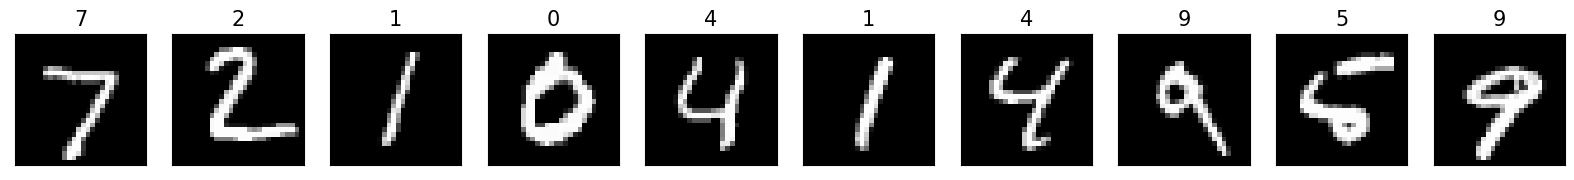

In [5]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(labels[i]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [6]:
def compute_loss_beta(model, x, beta):
    x_hat, kl_div = model(x)
    full_loss = recons_criterion(x_hat,x).mean(0).sum() - beta*(kl_div.mean(0).sum())
    return full_loss

def train_step_beta(model, x, optimizer, beta):
    # Compute the loss.
    model = model.to(device)
    x = x.to(device)
    loss = compute_loss_beta(model, x, beta)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

In [7]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 4
# Compute input dimensionality
imgs_test, labels = next(iter(test_loader))

nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
#encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes,conv_channels = 5)

from src.timbre_transfer.models.network import Encoder_MNIST, Decoder_MNIST

encoder = Encoder_MNIST.Encoder(nin, n_latent = n_latent, n_hidden = n_hidden)
decoder = Decoder_MNIST.Decoder(nin, n_latent = n_latent, n_hidden = n_hidden)

# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)

In [8]:
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Training using MSELoss and warm up procedure

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

In [9]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('VAE_mnist_peladeau.pt'):
    model.load_state_dict(torch.load('./VAE_mnist_peladeau.pt'))

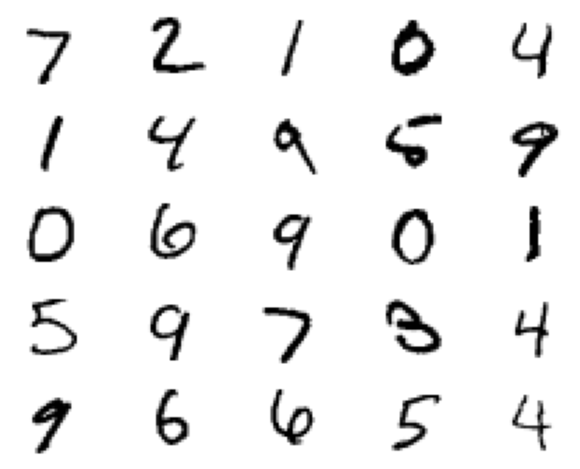

Epoch: 1, Test set ELBO: tensor([26086.0059], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


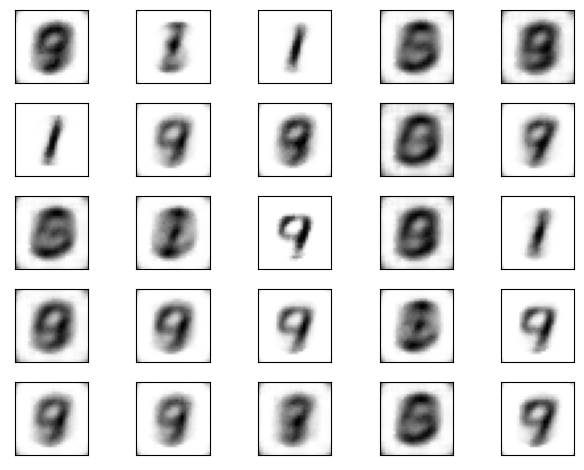

Epoch: 2, Test set ELBO: tensor([18238.5879], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


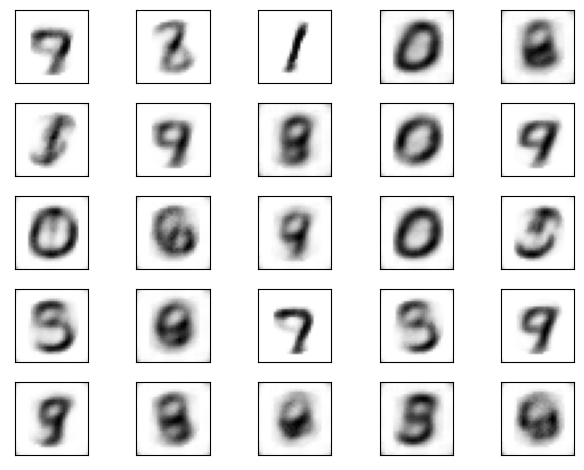

Epoch: 3, Test set ELBO: tensor([16220.6602], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


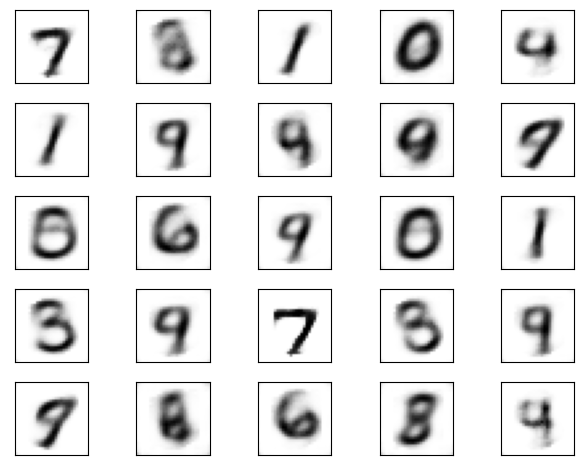

Epoch: 4, Test set ELBO: tensor([14771.6367], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


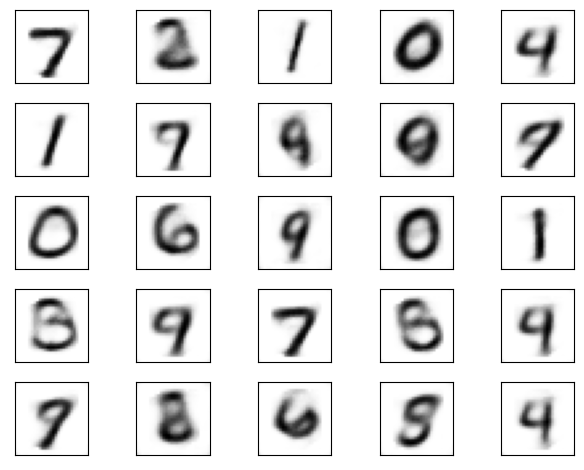

Epoch: 5, Test set ELBO: tensor([14202.3369], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


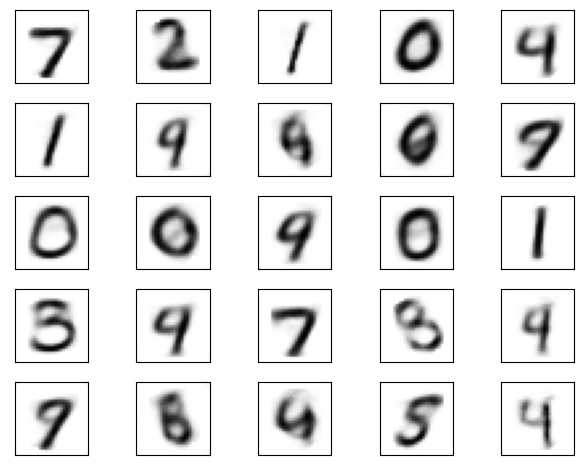

Epoch: 6, Test set ELBO: tensor([13905.8936], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


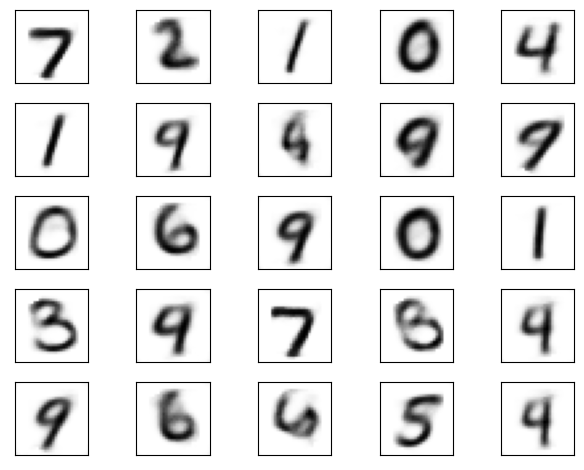

Epoch: 7, Test set ELBO: tensor([13707.3896], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


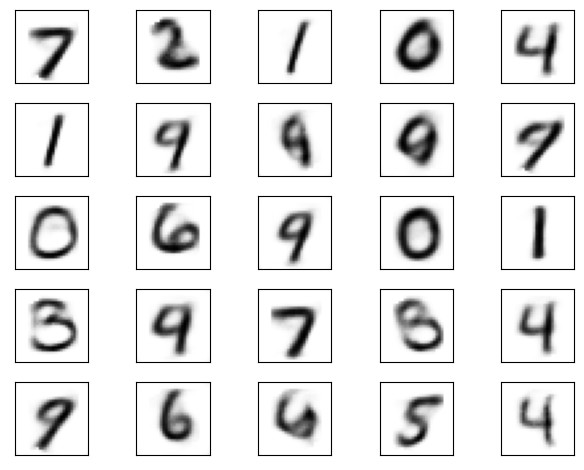

Epoch: 8, Test set ELBO: tensor([13569.2295], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


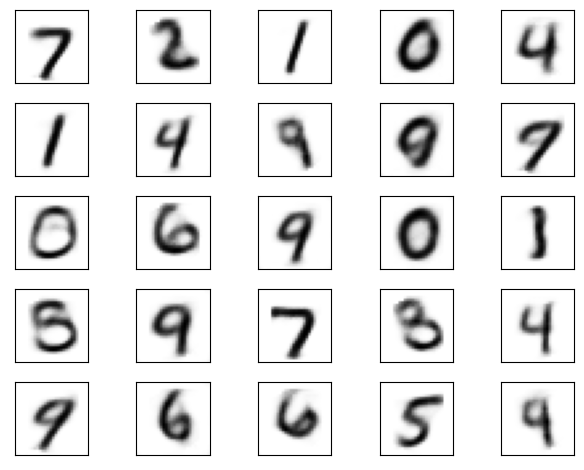

Epoch: 9, Test set ELBO: tensor([13458.6826], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


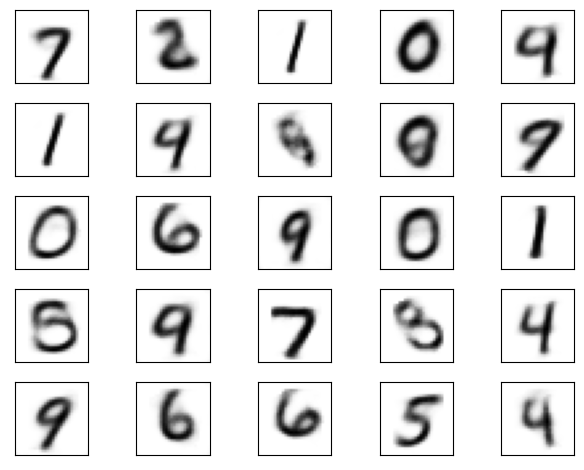

Epoch: 10, Test set ELBO: tensor([13346.3242], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


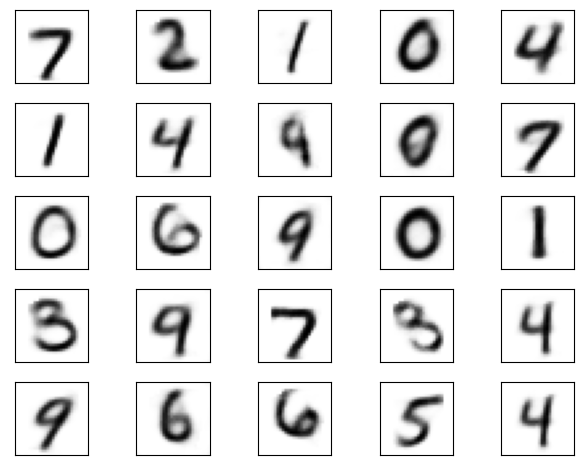

Epoch: 11, Test set ELBO: tensor([13263.5215], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


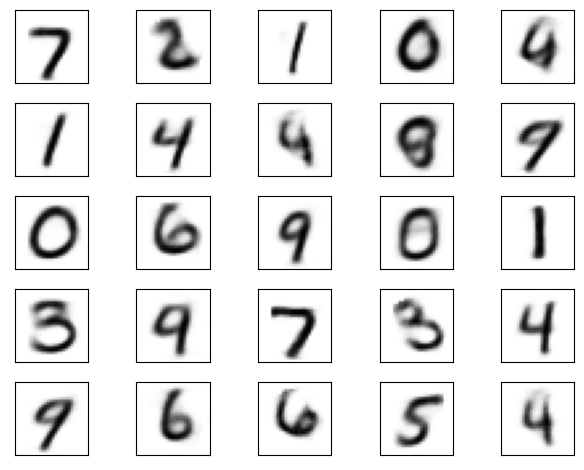

Epoch: 12, Test set ELBO: tensor([13203.3516], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


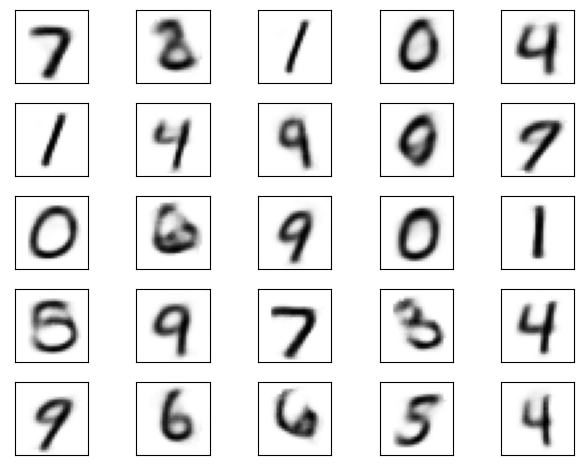

Epoch: 13, Test set ELBO: tensor([13132.2842], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


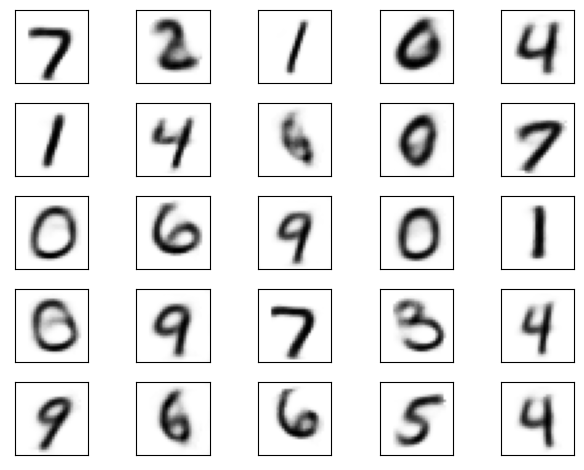

Epoch: 14, Test set ELBO: tensor([13066.5801], device='cuda:0', grad_fn=<AddBackward0>), beta : 3


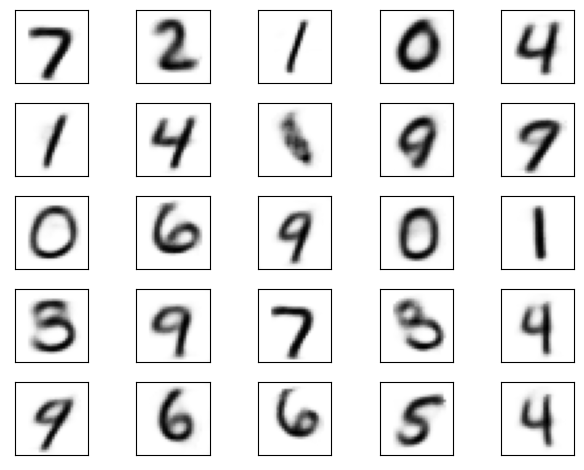

KeyboardInterrupt: 

In [10]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample.to(device))
    fig = plt.figure()
    for i in range(predictions.shape[0]):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(predictions[i, 0, :, :].cpu().detach(), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
    # Tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#writer = SummaryWriter()

#Warm up
N_warm_up = 15
beta_end = 3


epochs=20
test_sample = imgs_test[0:25, :, :, :].to(device)

fig = plt.figure()
for i in range(test_sample.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imgs_test[i, 0, :, :].cpu().detach(), cmap='gray_r')
    plt.axis('off')
# Tight_layout minimizes the overlap between 2 sub-plots
#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.tight_layout()
plt.show()
if train:
    for epoch in range(1, epochs + 1):
        full_loss = torch.Tensor([0]).to(device)
        if trainBeta and epoch<N_warm_up:
            beta = beta_end*epoch/N_warm_up
        else:
            beta = beta_end
        # Forward pass: compute predicted y by passing x to the model.
        for i, (x, _) in enumerate(train_loader):
            full_loss += train_step_beta(model, x, optimizer, beta)
        #for i, (x, _) in enumerate(valid_loader):
        #    train_step(model, x, optimizer)
        if epoch%1==0:
            print('Epoch: {}, Test set ELBO: {}, beta : {}'.format(epoch, full_loss, beta))
            #grid = torchvision.utils.make_grid(test_sample)
            #writer.add_image('images', grid, 0)
            #writer.add_image(test_sample, test_sample)
            #writer.close()
            generate_and_save_images(model, epoch, test_sample)

In [ ]:
# Save trained NN parameters
torch.save(model.state_dict(), 'VAE_mnist_peladeau.pt')


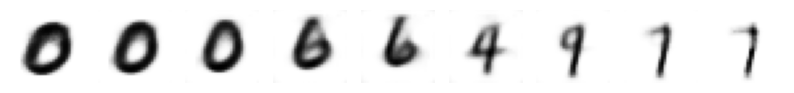

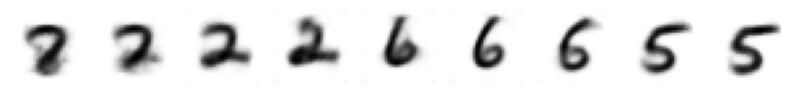

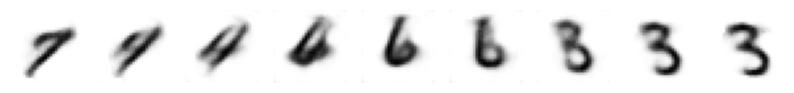

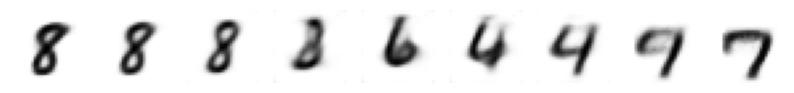

In [ ]:
mu = np.linspace(-2, 2, 9)


model = model.to(device)
for i in range(n_latent):
    fig = plt.figure(figsize=(10, 8))
    for j in range(9):
        final_tensor = torch.zeros(n_latent)
        plt.subplot(1, 9, j+1)
        final_tensor = torch.zeros(n_latent).to(device)
        final_tensor[i] = mu[j]
        plt.imshow(model.decode(final_tensor.to(device)).cpu().detach().reshape(28, 28), cmap='gray_r')
        plt.axis('off')
    plt.show()

### GAN Training

In [ ]:
dataset_dir = './../data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 0     # Loading the dataset is using 4 CPU threads
batch_size  = 32   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride = 1), nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride = 1), nn.ReLU(),
            #nn.Conv2d(conv_channels,conv_channels,3,padding = 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(((28-8)**2)*32, n_hidden), nn.ReLU(),
            nn.Linear(n_hidden, n_hidden), nn.ReLU(),
            nn.Linear(n_hidden, 1), nn.Sigmoid()
        )
            

    def forward(self, x):
        #x = x.view(-1, 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device)

In [ ]:
lr = 1e-4
loss_function = nn.MSELoss(reduction = 'mean')
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(model.decoder.parameters(), lr=lr)

Epoch : 0


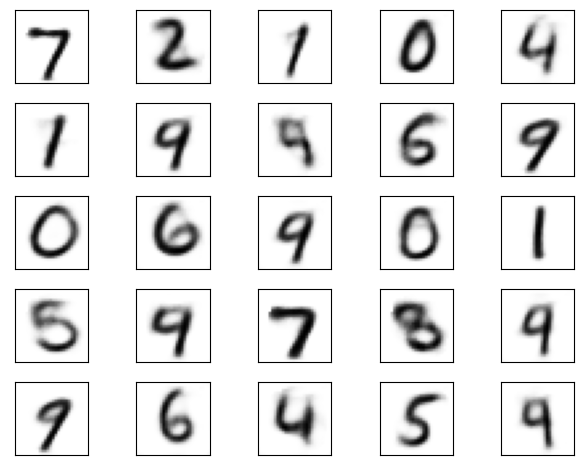

Epoch : 1


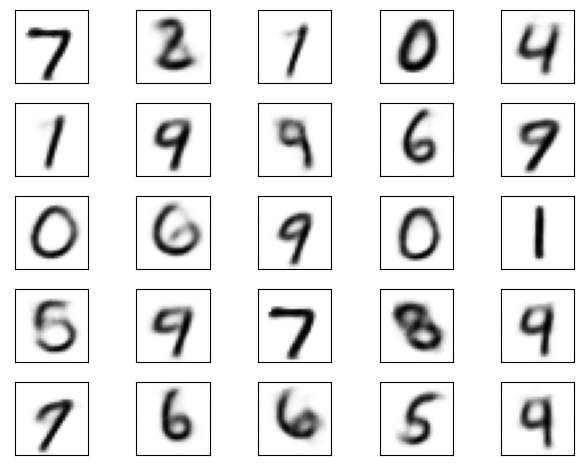

Epoch : 2


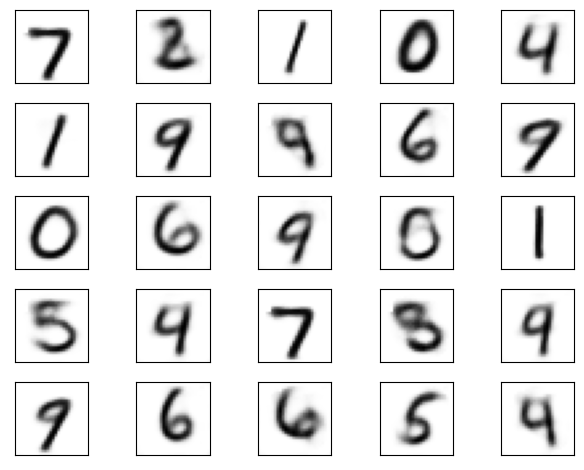

Epoch : 3


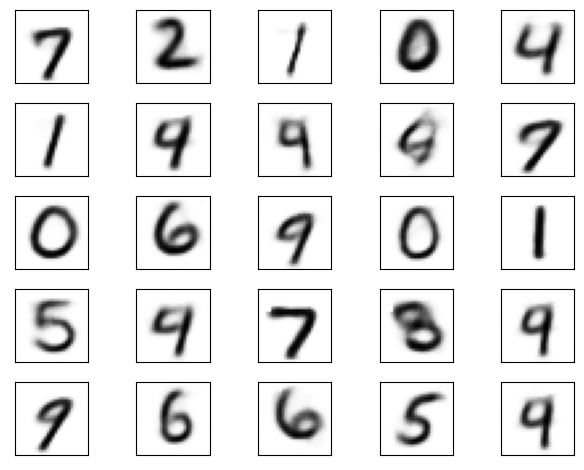

Epoch : 4


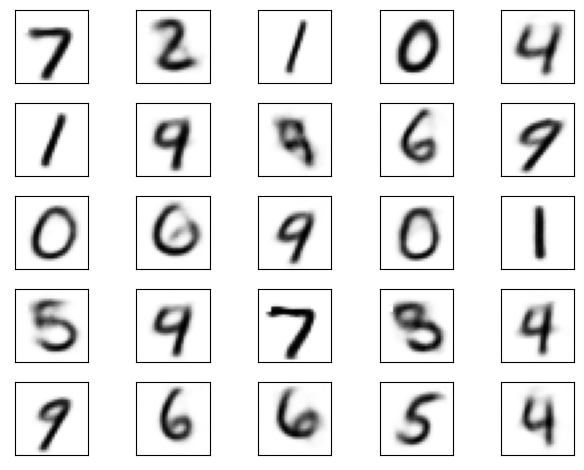

Epoch : 5


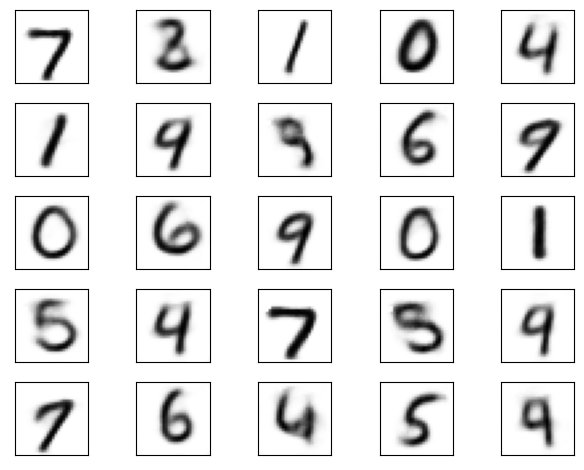

Epoch : 6


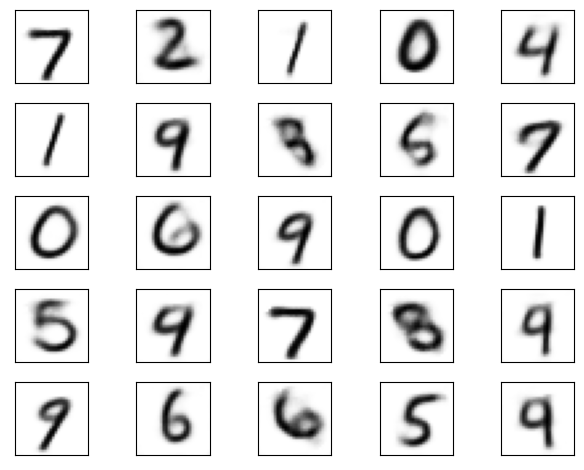

Epoch : 7


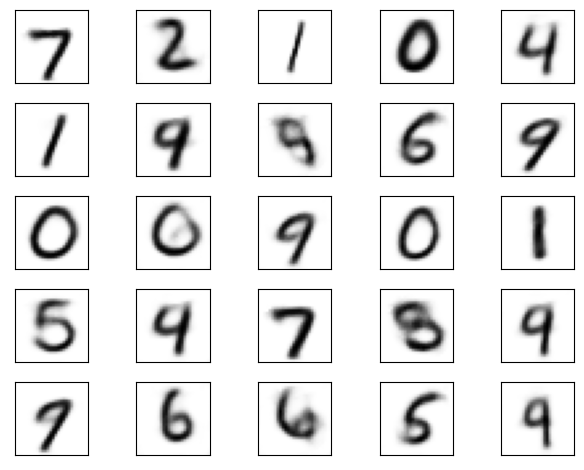

Epoch : 8


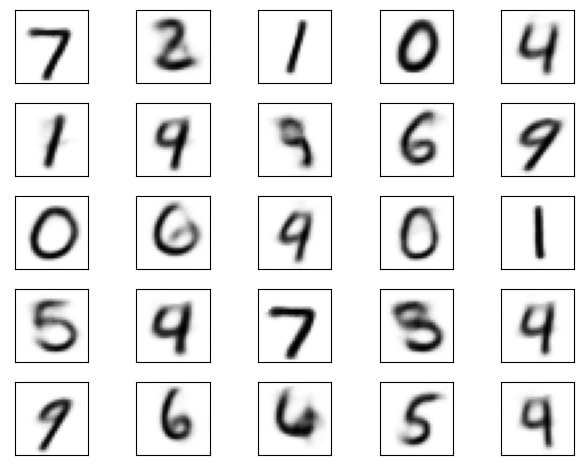

KeyboardInterrupt: 

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):

        ######################
        # YOUR CODE GOES HERE
        ######################

        #Generating fake samples
        real_samples = real_samples.to(device)
        
        z_params =  model.encode(real_samples)
        z_tilde, kl_div = model.latent(real_samples, z_params)

        fake_samples = model.decoder(z_tilde)
        real_samples = real_samples.to(device)
        
        
        real_class = discriminator(real_samples)
        fake_class = discriminator(fake_samples)
        #Calculating the discriminator loss
        dis_desired_real = torch.ones(real_class.size()[0],1).to(device)
        dis_desired_fake = torch.zeros(fake_class.size()[0],1).to(device)
        loss_discriminator = loss_function(torch.concat((real_class,fake_class)), torch.concat((dis_desired_real,dis_desired_fake)))

        #Optimizing the discriminator
        optimizer_discriminator.zero_grad()
        loss_discriminator.backward()
        optimizer_discriminator.step()

        #Calculating the generator loss
        z_params =  model.encode(real_samples)
        z_tilde, kl_div = model.latent(real_samples, z_params)
        fake_samples = model.decoder(z_tilde)

        fake_class = discriminator(fake_samples)
        gen_desired = torch.ones(fake_class.size()[0],1).to(device)
        loss_generator = loss_function(fake_class,gen_desired) + recons_criterion(fake_samples, real_samples).mean(0).sum() - kl_div.mean(0).sum()

        #optimizing the generator
        optimizer_generator.zero_grad()
        loss_generator.backward()
        optimizer_generator.step()
    # Show loss
    print(f"Epoch : {epoch}")
    generate_and_save_images(model, epoch, test_sample)
    #print(f"Loss D.: {loss_discriminator}")
    #print(f"Loss G.: {loss_generator}")
    #generated_samples = generator(latent_space_samples)
    #generated_samples = generated_samples.cpu().detach()

    #fig = plt.figure(figsize=(20,5))
    #for i in range(16):
    #    ax = plt.subplot(1, 16, i+1)
    #    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    #    plt.xticks([])
    #    plt.yticks([])
    #plt.tight_layout()
    #plt.show()

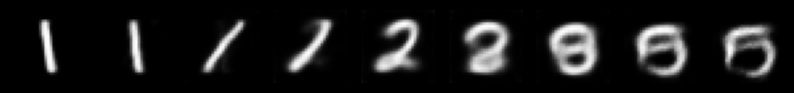

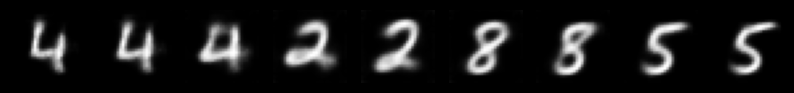

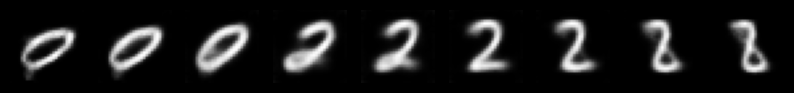

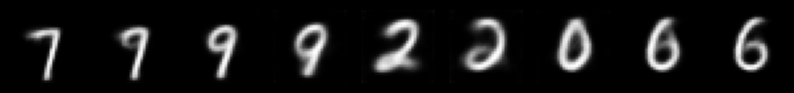

In [ ]:
mu = np.linspace(-2, 2, 9)


model = model.to(device)
for i in range(n_latent):
    fig = plt.figure(figsize=(10, 8))
    for j in range(9):
        final_tensor = torch.zeros(n_latent)
        plt.subplot(1, 9, j+1)
        final_tensor = torch.zeros(n_latent).to(device)
        final_tensor[i] = mu[j]
        plt.imshow(model.decode(final_tensor.to(device)).cpu().detach().reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

### Interpolating in the latent space

tensor(7)
tensor(2)
torch.Size([1, 1, 28, 28])
torch.Size([15, 1, 28, 28])


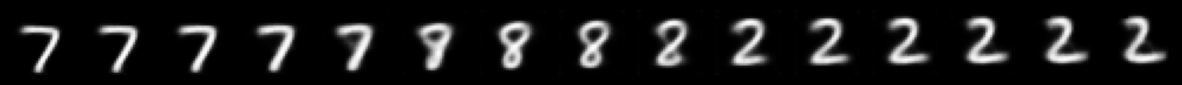

In [ ]:
def interpol_lin(model,x1,x2,n_steps):
    x1 = x1.to(device)
    x2 = x2.to(device)
    model = model.to(device)
    # Encoding to get both mu
    mu1,eps1 = model.encode(x1)
    mu2,eps2 = model.encode(x2)
    # Starting sample is decode(mu1)
    mu_int = mu1
    # Interpolating mu
    for n in range(1,n_steps):
        mu_int = torch.concat((mu_int, n/(n_steps-1)*mu2 + (n_steps-1-n)/(n_steps-1)*mu1))
    # Decoding
    imgs_out = model.decode(mu_int)
    return imgs_out

def interpol_sph(model,x1,x2,n_steps):
    x1 = x1.to(device)
    x2 = x2.to(device)
    model = model.to(device)
    # Encoding to get both mu
    mu1,eps1 = model.encode(x1)
    mu2,eps2 = model.encode(x2)
    
    r1 = torch.sqrt(torch.sum(torch.square(mu1)))
    r2 = torch.sqrt(torch.sum(torch.square(mu2)))
    
    
    phi1 = torch.zeros(mu1.size)
    phi2 = torch.zeros(mu2.size)
    # Interpolating mu
    for n in range(1,n_steps):
        mu_int = torch.concat((mu_int, n/(n_steps-1)*mu2 + (n_steps-1-n)/(n_steps-1)*mu1))
    # Decoding
    imgs_out = model.decode(mu_int)
    return imgs_out

n_images = 15

imgs_test, labels = next(iter(test_loader))
print(labels[0])
print(labels[1])

img0 = imgs_test[0,:,:,:].reshape(1,1,28,28)
img1 = imgs_test[1,:,:,:].reshape(1,1,28,28)
print(img0.size())
imgs_inter = interpol_lin(model,img0,img1,n_images)

print(imgs_inter.size())

fig = plt.figure(figsize=(n_images, 1))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(imgs_inter[i, 0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')


In [ ]:

fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imgs_test[i, 0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
# Tight_layout minimizes the overlap between 2 sub-plots
#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()